In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [139]:
from pandas.core.dtypes.common import is_datetime64_dtype
import numpy.typing as npt
from typing import Union, Tuple

nwp_path = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_3.zarr/"
gsp_path = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
gsp = xr.open_zarr(gsp_path)
nwp = xr.open_zarr(nwp_path)

evaluation_timeseries = gsp.coords["datetime_gmt"].where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0]) & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]), 
        drop=True).values

gsp = gsp.sel(datetime_gmt = evaluation_timeseries, gsp_id=0)


TRIG_DATETIME_FEATURE_NAMES = ["SIN_MONTH", "COS_MONTH", "SIN_DAY", "COS_DAY", "SIN_HOUR", "COS_HOUR"]


def _trig_transform(values: np.ndarray, period: Union[float, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given a list of values and an upper limit on the values, compute trig decomposition.
    Args:
        values: ndarray of points in the range [0, period]
        period: period of the data
    Returns:
        Decomposition of values into sine and cosine of data with given period
    """

    return np.sin(values * 2 * np.pi / period), np.cos(values * 2 * np.pi / period)


def trigonometric_datetime_transformation(datetimes: npt.ArrayLike) -> np.ndarray:
    """
    Given an iterable of datetimes, returns a trigonometric decomposition on hour, day and month
    Args:
        datetimes: ArrayLike of datetime64 values
    Returns:
        Trigonometric decomposition of datetime into hourly, daily and
        monthly values.
    """
    assert is_datetime64_dtype(datetimes), "Data for Trig Decomposition must be np.datetime64 type"

    datetimes = pd.DatetimeIndex(datetimes)
    hour = datetimes.hour.values.reshape(-1, 1) + (datetimes.minute.values.reshape(-1, 1) / 60)
    day = datetimes.day.values.reshape(-1, 1)
    month = datetimes.month.values.reshape(-1, 1)

    sine_hour, cosine_hour = _trig_transform(hour, 24)
    sine_day, cosine_day = _trig_transform(day, 366)
    sine_month, cosine_month = _trig_transform(month, 12)

    return np.concatenate(
        [sine_month, cosine_month, sine_day, cosine_day, sine_hour, cosine_hour], axis=1
    )



def build_datasets_from_local(step: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    X = np.load(f"/home/tom/local_data/geospatial_dsample_processed_nwp_data_step_28.npy")
    X = X.reshape(X.shape[2], X.shape[1]*4)
    # X =  np.nan_to_num(X)
    X = pd.DataFrame(data=X, index=evaluation_timeseries)
    y = pd.DataFrame(gsp["generation_mw"] / gsp["installedcapacity_mwp"], index=evaluation_timeseries, columns=["target"])
    
    # shift y by the step forecast
    shift = nwp.step.values[step]
    y = y.shift(freq=-shift).dropna()
    common_index=sorted(pd.DatetimeIndex((set(y.index).intersection(X.index))))
    
    X, y = X.loc[common_index], y.loc[common_index]
    
    # add datetime methods for the point at which we are forecasting e.g. now + step
    _X = trigonometric_datetime_transformation(y.shift(freq=nwp.step.values[step]).index.values)
    _X = pd.DataFrame(_X, index=y.index, columns=TRIG_DATETIME_FEATURE_NAMES)
    X = pd.concat([X, _X], axis=1)
    
    # add lagged values of GSP PV
    ar_1 = y.shift(freq = -(shift + np.timedelta64(1, "h")))
    ar_day = y.shift(freq = - (shift + np.timedelta64(1, "D")))
    ar_1.columns = ["PV_LAG_1HR"]
    ar_day.columns = ["PV_LAG_DAY"]
    
    # estimate linear trend of the PV
    window_size = 10
    epsilon = 0.01
    y_covariates = y.shift(freq = -(shift + np.timedelta64(2, "h")))
    y_covariates.columns = ["x"]
    y_target = y.shift(freq = -(shift + np.timedelta64(1, "h")))
    y_target.columns = ["y"]
    data = pd.concat([y_target, y_covariates], axis=1).dropna()
    _x = data["x"].values
    _y = data["y"].values
    _betas = np.nan * np.empty(len(data))
    
    for n in range(window_size, len(data)):
        __y = _y[(n-window_size): n]
        __x = _x[(n-window_size): n]
        __b = max(min((1 / ((__x.T @ __x) + epsilon))  * (__x.T @ __y), 10), -10)
        _betas[n] = __b
    
    betas = pd.DataFrame(data=_betas, columns=["AR_Beta"], index=data.index)
    
    X = pd.concat([X, ar_1, ar_day, betas], axis=1).dropna()
    y = y.loc[X.index]
    
    
    return X, y

In [140]:
X, y = build_datasets_from_local(28)

In [141]:
X

,0,1,2,3,4,5,6,7,8,9,...,67,SIN_MONTH,COS_MONTH,SIN_DAY,COS_DAY,SIN_HOUR,COS_HOUR,PV_LAG_1HR,PV_LAG_DAY,AR_Beta
2020-02-09 21:00:00,7.990513e+01,7.715796e+01,85.162182,90.311774,7.952634e+01,7.881084e+01,84.319893,90.322388,7.928235e+01,8.015311e+01,...,91.384275,0.866025,0.500000,0.187719,0.982223,0.258819,0.965926,0.000000,0.000000,0.000000
2020-02-09 21:30:00,6.399160e+01,8.119602e+01,78.314175,90.412335,6.112868e+01,7.942073e+01,77.695860,89.282241,5.804785e+01,7.805162e+01,...,86.600751,0.866025,0.500000,0.187719,0.982223,0.382683,0.923880,0.000000,0.000000,0.000000
2020-02-09 22:00:00,3.676422e+01,5.297664e+01,61.355888,86.607993,3.650448e+01,4.952470e+01,57.833117,86.414397,3.648466e+01,4.636045e+01,...,70.513555,0.866025,0.500000,0.187719,0.982223,0.500000,0.866025,0.000000,0.000000,0.000000
2020-02-09 22:30:00,4.333442e+01,3.254600e+01,29.536685,68.290318,4.292855e+01,3.227960e+01,28.350367,65.872187,4.257535e+01,3.214956e+01,...,28.948845,0.866025,0.500000,0.187719,0.982223,0.608761,0.793353,0.000000,0.000000,0.000000
2020-02-09 23:00:00,6.435332e+01,4.991795e+01,26.941734,27.338852,6.627568e+01,5.153794e+01,27.590881,25.708642,6.793291e+01,5.306001e+01,...,19.302342,0.866025,0.500000,0.187719,0.982223,0.707107,0.707107,0.006200,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-05 05:00:00,2.879172e-06,8.418742e-06,0.000101,0.000002,2.656611e-06,7.705717e-06,0.000110,0.000003,2.401512e-06,7.030483e-06,...,0.000007,-0.500000,0.866025,0.102821,0.994700,0.707107,-0.707107,0.220691,0.191085,0.923036
2021-11-05 05:30:00,7.248252e-07,3.139897e-06,0.000132,0.000008,8.076284e-07,3.156226e-06,0.000121,0.000010,8.527023e-07,3.111874e-06,...,0.000017,-0.500000,0.866025,0.102821,0.994700,0.608761,-0.793353,0.177553,0.159681,0.966361
2021-11-05 06:00:00,1.064345e-06,2.348873e-06,0.000064,0.000018,1.078408e-06,2.438651e-06,0.000069,0.000020,1.161053e-06,2.483708e-06,...,0.000033,-0.500000,0.866025,0.102821,0.994700,0.500000,-0.866025,0.128269,0.144202,1.012973
2021-11-05 06:30:00,3.122503e-06,5.328724e-07,0.000079,0.000033,3.038760e-06,4.134728e-07,0.000079,0.000031,3.073149e-06,3.252628e-07,...,0.000011,-0.500000,0.866025,0.102821,0.994700,0.382683,-0.923880,0.071450,0.093407,1.057241


In [147]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dataclasses import dataclass

DEFFAULT_HYPARAM_CONFIG = {
               'objective': 'reg:squarederror',
               'booster': 'gbtree',
               'colsample_bylevel': 1,
               'colsample_bynode': 1,
               'colsample_bytree': 0.85,
               'early_stopping_rounds': None,
               'gamma': 0,
               'gpu_id': -1,
               'grow_policy': 'depthwise',
               'importance_type': None,
               'interaction_constraints': '',
               'learning_rate': 0.005,
               'max_bin': 256,
               'max_cat_threshold': 64,
               'max_depth': 100,
               'max_leaves': 0,
               'min_child_weight': 5,
               'n_estimators': 6_000,
               'n_jobs': -1,
               'num_parallel_tree': 1,
               'predictor': 'auto',
               'random_state': 0,
               'reg_alpha': 0,
               'reg_lambda': 1,
               'sampling_method': 'uniform',
               'scale_pos_weight': 1,
               'subsample': 0.65,
               'tree_method': 'hist',
               'validate_parameters': 1,
               'verbosity': 1
 }


@dataclass
class ExperimentSummary:
    mse_train_loss: float
    mse_test_loss: float
    mae_train_loss: float
    mae_test_loss: float
    model: XGBRegressor



def run_experiment(X: pd.DataFrame,
                   y: pd.DataFrame,
                   booster_hyperparam_config: dict = DEFFAULT_HYPARAM_CONFIG
                   ) -> ExperimentSummary:

    # use 2020 as training period and 2021 as test
    X_train, y_train = X.loc[X.index < "2021-01-01"], y.loc[y.index < "2021-01-01"]
    X_test, y_test = X.loc[X.index >= "2021-01-01"], y.loc[y.index >= "2021-01-01"]

    model = XGBRegressor(**booster_hyperparam_config)
    model.fit(X_train, y_train)
    
    y_pred_test, y_pred_train = model.predict(X_test), model.predict(X_train)
    train_mse, test_mse = mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)
    train_mae, test_mae = mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)
        
    
    return ExperimentSummary(
        train_mse,
        test_mse,
        train_mae,
        test_mae,
        model  # just save the last trained model for nwp
    )
        

In [148]:
results = run_experiment(X, y)

<AxesSubplot: >

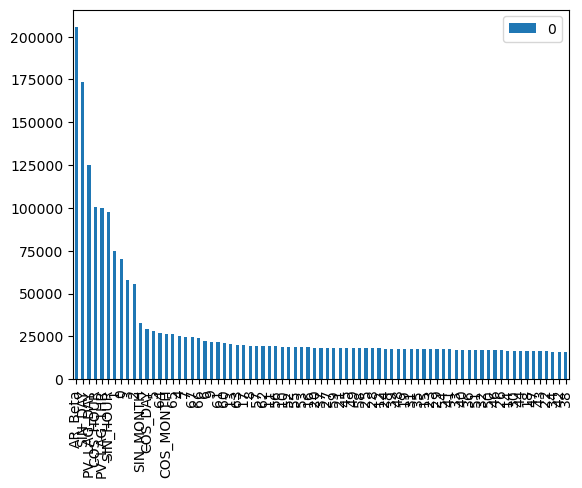

In [149]:
pd.DataFrame.from_dict(results.model.get_booster().get_score(importance_type='weight'), orient="index").sort_values(by=0, ascending=False).plot.bar()

In [153]:
pd.DataFrame.from_dict(results.model.get_booster().get_score(importance_type='gain'), orient="index").sort_values(by=0, ascending=False).head(20)

,0
AR_Beta,0.081702
COS_MONTH,0.075118
COS_HOUR,0.037161
SIN_MONTH,0.021651
COS_DAY,0.007751
26,0.006656
SIN_DAY,0.006563
PV_LAG_DAY,0.005380
SIN_HOUR,0.005184
39,0.003856


<AxesSubplot: >

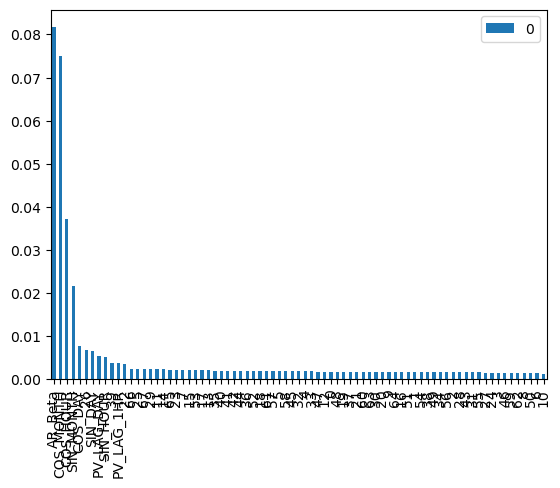

In [150]:
pd.DataFrame.from_dict(results.model.get_booster().get_score(importance_type='gain'), orient="index").sort_values(by=0, ascending=False).plot.bar()

In [146]:
results

ExperimentSummary(mse_train_loss=6.800237283340294e-07, mse_test_loss=0.004188799559006067, mae_train_loss=0.00035988602563645093, mae_test_loss=0.034078830240757675, model=XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.85,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.005, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=100, max_leaves=0, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=3000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, ...))

In [83]:
import requests
from ocf_datapipes.utils.geospatial import osgb_to_lat_lon
import geopandas as gpd

url = (
            "https://data.nationalgrideso.com/backend/dataset/2810092e-d4b2-472f-b955-d8bea01f9ec0/"
            "resource/08534dae-5408-4e31-8639-b579c8f1c50b/download/gsp_regions_20220314.geojson"
        )

with requests.get(url) as response:
    shape_gpd = gpd.read_file(response.text)

    # calculate the centroid before using - to_crs
    shape_gpd["centroid_x"] = shape_gpd["geometry"].centroid.x
    shape_gpd["centroid_y"] = shape_gpd["geometry"].centroid.y
    shape_gpd["centroid_lat"], shape_gpd["centroid_lon"] = osgb_to_lat_lon(
        x=shape_gpd["centroid_x"], y=shape_gpd["centroid_y"]
    )

    # Decided not project the shape data to WGS84, as we want to keep
    # all 'batch' data the same projection.
    # However when plotting it may be useful to project to WGS84
    # i.e shape_gpd = shape_gpd.to_crs(WGS84_CRS)

    # TODO is this right?
    # latest geo json does not have region id in it, so add this for the moment
    shape_gpd.sort_values("GSPs", inplace=True)
    shape_gpd.reset_index(inplace=True, drop=True)
    shape_gpd["RegionID"] = range(1, len(shape_gpd) + 1)

In [264]:
import sys

sys.path.append("../gradboost_pv/")

In [265]:
from gradboost_pv.preprocessing.geospatial import get_eso_uk_multipolygon, check_point_in_multipolygon, check_points_in_multipolygon_multiprocessed

In [267]:
uk_poly2 = get_eso_uk_multipolygon()

/home/tom/dev/gradboost_pv/gradboost_pv/preprocessing/geospatial.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return MultiPolygon(


In [278]:
coords = list(map(lambda x: Point(x[0], x[1]), itertools.product(nwp.coords["x"].values, nwp.coords["y"].values)))

In [288]:
mat = check_points_in_multipolygon_multiprocessed(coords, uk_poly2)

In [292]:
bool_mask = mat.reshape(len(nwp.coords["x"]), len(nwp.coords["y"])).T

In [309]:
nan_mask = bool_mask.copy()

In [324]:
flipped = (nan_mask).astype(float)

In [325]:
flipped[flipped == 0] = np.nan

In [326]:
np.unique(flipped)

array([ 1., nan])

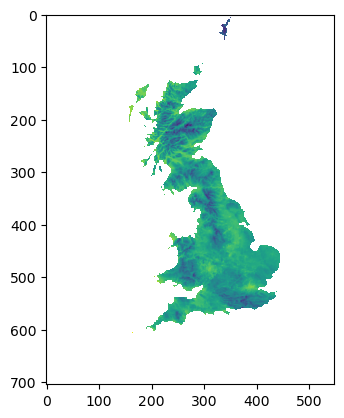

In [328]:
plt.imshow(flipped *  nwp.isel(init_time=30, variable=9, step=1).to_array().values.reshape(704, 548))

In [339]:
subset = nwp.isel(step=[1,2,5], variable=9).to_array()

In [340]:
masked = subset * flipped

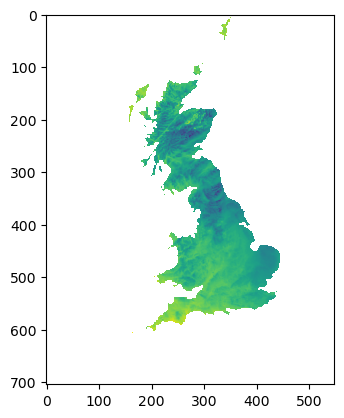

In [342]:
plt.imshow(masked.isel(init_time=4, step=2).values.reshape(704, 548))

In [ ]:
subset.where(flipped)

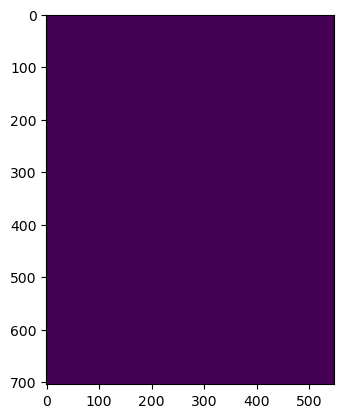

In [296]:
plt.imshow(nan_mask)

In [281]:
nwp

<xarray.Dataset>
Dimensions:    (variable: 17, init_time: 5319, step: 37, y: 704, x: 548)
Coordinates:
  * init_time  (init_time) datetime64[ns] 2020-01-01 ... 2021-11-08T15:00:00
  * step       (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * variable   (variable) <U6 'cdcb' 'lcc' 'mcc' ... 'wdir10' 'prmsl' 'prate'
  * x          (x) int64 -239000 -237000 -235000 ... 851000 853000 855000
  * y          (y) int64 1223000 1221000 1219000 ... -179000 -181000 -183000
Data variables:
    UKV        (variable, init_time, step, y, x) float32 dask.array<chunksize=(17, 1, 1, 352, 274), meta=np.ndarray>

In [154]:
nwp.x

<xarray.DataArray 'x' (x: 548)>
array([-239000, -237000, -235000, ...,  851000,  853000,  855000])
Coordinates:
  * x        (x) int64 -239000 -237000 -235000 -233000 ... 851000 853000 855000

<AxesSubplot: >

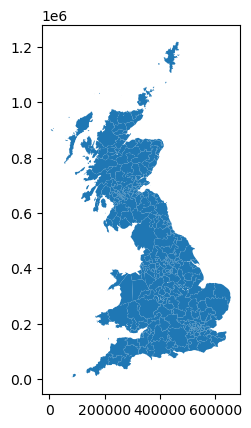

In [85]:
shape_gpd.plot()

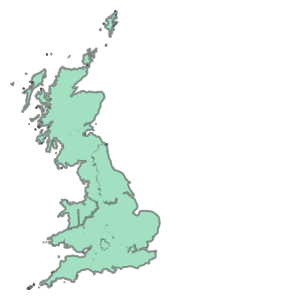

In [171]:
total.iloc[0]

In [212]:
from shapely.geometry import Point
import itertools

uk_poly = total.loc[0]
coords = list(itertools.product(nwp.coords["x"].values, nwp.coords["y"].values))

In [213]:
len(coords)

385792

In [230]:
test = coords[:100_000]

In [241]:
z = np.asarray([output.contains(Point(x)) for x in coords]).reshape(len(nwp.coords["x"]), len(nwp.coords["y"]))

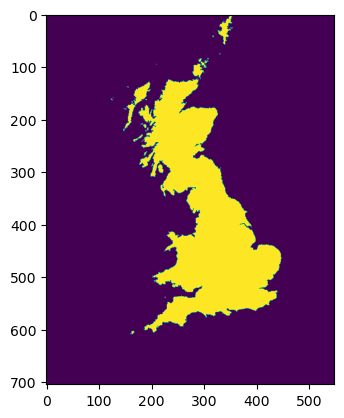

In [244]:
plt.imshow(z.T)

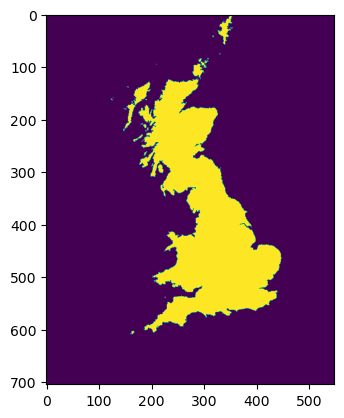

In [251]:
plt.imshow(a
    z.astype(int).T)

In [261]:
z[~(z)] = np.nan

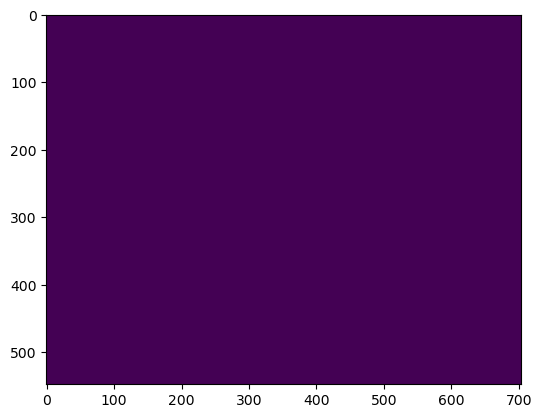

In [263]:
plt.imshow(z)

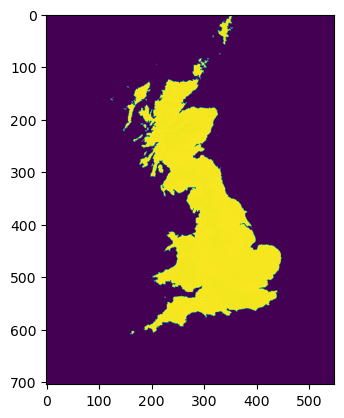

In [253]:
plt.imshow(nwp.isel(init_time=30, variable=9, step=1).to_array().values.reshape(704, 548) * mask) 

In [219]:
from numba import jit, njit
import numba

@jit(nopython=True)
def is_inside_sm(polygon, point):
    length = len(polygon)-1
    dy2 = point[1] - polygon[0][1]
    intersections = 0
    ii = 0
    jj = 1

    while ii<length:
        dy  = dy2
        dy2 = point[1] - polygon[jj][1]

        # consider only lines which are not completely above/bellow/right from the point
        if dy*dy2 <= 0.0 and (point[0] >= polygon[ii][0] or point[0] >= polygon[jj][0]):

            # non-horizontal line
            if dy<0 or dy2<0:
                F = dy*(polygon[jj][0] - polygon[ii][0])/(dy-dy2) + polygon[ii][0]

                if point[0] > F: # if line is left from the point - the ray moving towards left, will intersect it
                    intersections += 1
                elif point[0] == F: # point on line
                    return 2

            # point on upper peak (dy2=dx2=0) or horizontal line (dy=dy2=0 and dx*dx2<=0)
            elif dy2==0 and (point[0]==polygon[jj][0] or (dy==0 and (point[0]-polygon[ii][0])*(point[0]-polygon[jj][0])<=0)):
                return 2

        ii = jj
        jj += 1

    #print 'intersections =', intersections
    return intersections & 1  


@njit(parallel=True)
def is_inside_sm_parallel(points, polygon):
    ln = len(points)
    D = np.empty(ln, dtype=numba.boolean) 
    for i in numba.prange(ln):
        D[i] = is_inside_sm(polygon,points[i])
    return D  
    return D  

In [220]:
is_inside_sm(uk_poly, coords[0])

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
During: typing of argument at /tmp/ipykernel_122260/4253388263.py (6)

File "../../../../tmp/ipykernel_122260/4253388263.py", line 6:
<source missing, REPL/exec in use?> 

This error may have been caused by the following argument(s):
- argument 0: Cannot determine Numba type of <class 'shapely.geometry.multipolygon.MultiPolygon'>


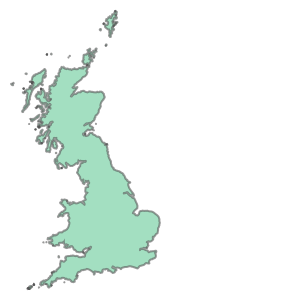

In [225]:
output

AttributeError: 'MultiPolygon' object has no attribute 'to_numpy'

In [211]:
points = np.asarray(list(uk_poly.contains(Point(x)) for x in coords))

KeyboardInterrupt: 

In [ ]:
points

array([], dtype=float64)

In [208]:
points.reshape(len(nwp.coords["x"]), len(nwp.coords["y"]))

ValueError: cannot reshape array of size 0 into shape (548,704)

In [195]:
total.loc[0].contains(points[250])

True

In [158]:
nwp.

AttributeError: 'Dataset' object has no attribute 'geobox'

In [91]:
from shapely.ops import unary_union
total = gpd.GeoSeries(unary_union(shape_gpd["geometry"].values))

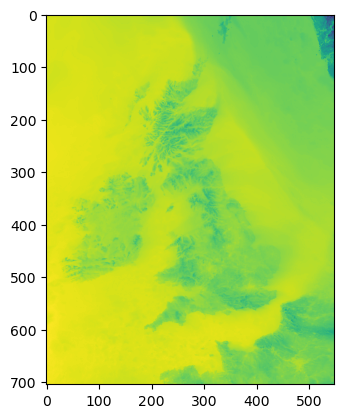

In [137]:
plt.imshow(nwp.isel(init_time=30, variable=9, step=1).to_array().values.reshape(704, 548))

<AxesSubplot: >

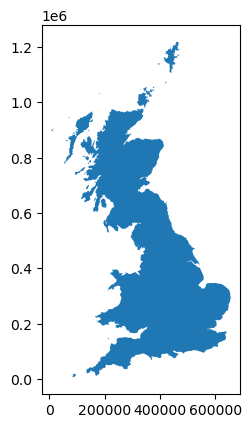

In [92]:
total.plot()

In [95]:
total

0    MULTIPOLYGON (((84080.000 5300.000, 84080.000 ...
dtype: geometry

In [94]:
from shapely.ops import split
from shapely.geometry import LineString

In [100]:
splitter = LineString([(0, 0.5*1e6), (800_000, 0.5*1e6)])

In [115]:
total.explode(index_parts=False)

0    POLYGON ((84080.000 5300.000, 84080.000 5250.0...
0    POLYGON ((84940.000 5530.000, 84920.000 5490.0...
0    POLYGON ((84050.000 5540.000, 84000.000 5590.0...
0    POLYGON ((83990.000 5860.000, 83940.000 5830.0...
0    POLYGON ((84970.000 5980.000, 84880.000 5990.0...
                           ...                        
0    POLYGON ((453140.000 1173810.000, 453100.000 1...
0    POLYGON ((464500.000 1203330.000, 464550.000 1...
0    POLYGON ((460460.000 1219650.000, 460510.000 1...
0    POLYGON ((461237.000 1220373.000, 461408.000 1...
0    POLYGON ((599695.147 183259.000, 599718.147 18...
Length: 153, dtype: geometry

In [119]:
res  = {"a": split(total.explode(index_parts=False).iloc[0], splitter)}

In [120]:
res

{'a': <shapely.geometry.collection.GeometryCollection at 0x7fa121389a20>}

In [123]:
from shapely.geometry import MultiPolygon, Polygon

output = MultiPolygon(Polygon(p.exterior) for p in total.values[0])

/tmp/ipykernel_122260/2335711015.py:3: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  output = MultiPolygon(Polygon(p.exterior) for p in total.values[0])


In [128]:
split_output = split(output, splitter)

In [130]:
dir(split_output)

['__and__',
 '__array_interface__',
 '__bool__',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__geo_interface__',
 '__geom__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__p__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__weakref__',
 '__xor__',
 '_array_interface_base',
 '_crs',
 '_ctypes',
 '_ctypes_data',
 '_empty',
 '_geom',
 '_get_coords',
 '_is_empty',
 '_lgeos',
 '_ndim',
 '_other_owned',
 '_repr_svg_',
 '_set_coords',
 '_set_geom',
 'almost_equals',
 'area',
 'array_interface_base',
 'boundary',
 'bounds',
 'buffer',
 'centroid',
 'contains',
 'convex_hull',
 'coords',
 'covered_by',
 'covers',
 'crosses',
 'ctypes',
 'difference',
 'disjoint',


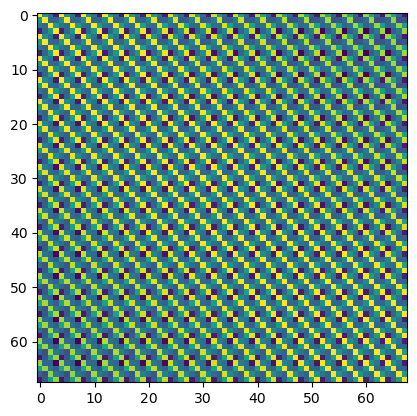

In [60]:
plt.imshow(pd.DataFrame(X).corr())